In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [36]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -100 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [38]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [18]:

N = 400
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.95
ϵ = 0.2
x = [20, 60, 90, 1, 1];
λ = 0.95
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0
epochsize = 200

0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);
# train/test loop, raising epoch size

epochs = 25000


total = 0
rando = 0
test = false
k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
u = uu[1]
rando += uu[2]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
    u = uu[1]
    if test == true u = uu[3] end
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    

        
    if (counter % epochsize == 0) || (xp[1] <= 10)
        push!(totals, total*500/epochsize)
        running_avg = round(mean(totals), sigdigits=4) 
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", running_avg,
            " Epoch: ", trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
        
        if counter % (epochsize*200) == 0
            test = true
            println("---------- TESTING -------------")
            totals = [0.0]
        end
        if counter % (epochsize*300) == 0
            if (running_avg > 30)
                totals = [0.0]
                test = false
                counter = 0
                epochsize += 50
                println("------ NEW EPOCH SIZE: ", epochsize, " -------------")
            else
                counter = 0
                test = false
                totals = [0.0]
                println("---------- TRAINING -------------")
            end    
        end
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current474.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 22.76 AVG: 40.9 Epoch: 118 -----------
--------- CURRENT: 50.0 AVG: 40.98 Epoch: 119 -----------
--------- CURRENT: 50.0 AVG: 41.05 Epoch: 120 -----------
--------- CURRENT: -5.294 AVG: 40.68 Epoch: 120 -----------
--------- CURRENT: 49.35 AVG: 40.75 Epoch: 121 -----------
--------- CURRENT: 50.0 AVG: 40.82 Epoch: 122 -----------
--------- CURRENT: -4.294 AVG: 40.48 Epoch: 122 -----------
--------- CURRENT: 48.35 AVG: 40.54 Epoch: 123 -----------
--------- CURRENT: 50.0 AVG: 40.61 Epoch: 124 -----------
--------- CURRENT: 33.76 AVG: 40.56 Epoch: 125 -----------
--------- CURRENT: 42.94 AVG: 40.57 Epoch: 126 -----------
--------- CURRENT: 50.0 AVG: 40.64 Epoch: 127 -----------
--------- CURRENT: 50.0 AVG: 40.71 Epoch: 128 -----------
--------- CURRENT: 50.0 AVG: 40.78 Epoch: 129 -----------
--------- CURRENT: 50.0 AVG: 40.85 Epoch: 130 -----------
--------- CURRENT: 50.0 AVG: 40.91 Epoch: 131 -----------
--------- CURRENT: 50.0 AVG: 40.98 Epoch: 132 -----------
------

--------- CURRENT: 50.0 AVG: 29.8 Epoch: 248 -----------
--------- CURRENT: 46.82 AVG: 30.1 Epoch: 249 -----------
--------- CURRENT: 50.0 AVG: 30.44 Epoch: 250 -----------
--------- CURRENT: 50.0 AVG: 30.78 Epoch: 251 -----------
--------- CURRENT: -99.65 AVG: 28.6 Epoch: 252 -----------
--------- CURRENT: 50.0 AVG: 28.95 Epoch: 253 -----------
--------- CURRENT: 50.0 AVG: 29.29 Epoch: 254 -----------
--------- CURRENT: 10.35 AVG: 28.99 Epoch: 254 -----------
--------- CURRENT: 33.71 AVG: 29.07 Epoch: 255 -----------
--------- CURRENT: 50.0 AVG: 29.39 Epoch: 256 -----------
--------- CURRENT: 50.0 AVG: 29.7 Epoch: 257 -----------
--------- CURRENT: 50.0 AVG: 30.0 Epoch: 258 -----------
--------- CURRENT: 50.0 AVG: 30.3 Epoch: 259 -----------
--------- CURRENT: 50.0 AVG: 30.58 Epoch: 260 -----------
--------- CURRENT: -9.294 AVG: 30.01 Epoch: 261 -----------
--------- CURRENT: 50.0 AVG: 30.29 Epoch: 262 -----------
--------- CURRENT: 50.0 AVG: 30.57 Epoch: 263 -----------
--------- CUR

--------- CURRENT: 50.0 AVG: 42.19 Epoch: 85 -----------
--------- CURRENT: 50.0 AVG: 42.28 Epoch: 86 -----------
--------- CURRENT: 50.0 AVG: 42.36 Epoch: 87 -----------
--------- CURRENT: 50.0 AVG: 42.45 Epoch: 88 -----------
--------- CURRENT: 50.0 AVG: 42.53 Epoch: 89 -----------
--------- CURRENT: 50.0 AVG: 42.61 Epoch: 90 -----------
--------- CURRENT: 50.0 AVG: 42.69 Epoch: 91 -----------
--------- CURRENT: 50.0 AVG: 42.76 Epoch: 92 -----------
--------- CURRENT: 7.667 AVG: 42.4 Epoch: 93 -----------
--------- CURRENT: -42.33 AVG: 41.54 Epoch: 94 -----------
--------- CURRENT: 29.17 AVG: 41.41 Epoch: 95 -----------
--------- CURRENT: 50.0 AVG: 41.5 Epoch: 96 -----------
--------- CURRENT: 50.0 AVG: 41.58 Epoch: 97 -----------
--------- CURRENT: 50.0 AVG: 41.66 Epoch: 98 -----------
--------- CURRENT: 50.0 AVG: 41.74 Epoch: 99 -----------
--------- CURRENT: 50.0 AVG: 41.82 Epoch: 100 -----------
--------- CURRENT: -4.722 AVG: 41.38 Epoch: 100 -----------
--------- CURRENT: -43.22

--------- CURRENT: -75.33 AVG: 25.43 Epoch: 218 -----------
--------- CURRENT: 50.0 AVG: 26.6 Epoch: 219 -----------
--------- CURRENT: 50.0 AVG: 27.66 Epoch: 220 -----------
--------- CURRENT: 50.0 AVG: 28.63 Epoch: 221 -----------
--------- CURRENT: 50.0 AVG: 29.52 Epoch: 222 -----------
--------- CURRENT: 50.0 AVG: 30.34 Epoch: 223 -----------
--------- CURRENT: 50.0 AVG: 31.1 Epoch: 224 -----------
--------- CURRENT: 11.0 AVG: 30.35 Epoch: 225 -----------
--------- CURRENT: -79.17 AVG: 26.44 Epoch: 226 -----------
--------- CURRENT: -75.83 AVG: 22.92 Epoch: 227 -----------
--------- CURRENT: 50.0 AVG: 23.82 Epoch: 228 -----------
--------- CURRENT: 50.0 AVG: 24.66 Epoch: 229 -----------
--------- CURRENT: -52.5 AVG: 22.25 Epoch: 230 -----------
--------- CURRENT: 50.0 AVG: 23.09 Epoch: 231 -----------
--------- CURRENT: 50.0 AVG: 23.88 Epoch: 232 -----------
--------- CURRENT: 23.33 AVG: 23.87 Epoch: 232 -----------
--------- CURRENT: 21.06 AVG: 23.79 Epoch: 233 -----------
-------

--------- CURRENT: 50.0 AVG: 40.99 Epoch: 56 -----------
--------- CURRENT: 50.0 AVG: 41.14 Epoch: 57 -----------
--------- CURRENT: 50.0 AVG: 41.29 Epoch: 58 -----------
--------- CURRENT: 49.53 AVG: 41.42 Epoch: 59 -----------
--------- CURRENT: 50.0 AVG: 41.56 Epoch: 60 -----------
--------- CURRENT: 50.0 AVG: 41.69 Epoch: 61 -----------
--------- CURRENT: 50.0 AVG: 41.82 Epoch: 62 -----------
--------- CURRENT: 50.0 AVG: 41.95 Epoch: 63 -----------
--------- CURRENT: 37.37 AVG: 41.88 Epoch: 64 -----------
--------- CURRENT: 50.0 AVG: 42.0 Epoch: 65 -----------
--------- CURRENT: 50.0 AVG: 42.12 Epoch: 66 -----------
--------- CURRENT: 50.0 AVG: 42.23 Epoch: 67 -----------
--------- CURRENT: 37.37 AVG: 42.16 Epoch: 68 -----------
--------- CURRENT: 50.0 AVG: 42.27 Epoch: 69 -----------
--------- CURRENT: 50.0 AVG: 42.38 Epoch: 70 -----------
--------- CURRENT: 50.0 AVG: 42.49 Epoch: 71 -----------
--------- CURRENT: 50.0 AVG: 42.59 Epoch: 72 -----------
--------- CURRENT: 50.0 AVG: 

--------- CURRENT: 50.0 AVG: 42.55 Epoch: 192 -----------
--------- CURRENT: 50.0 AVG: 42.59 Epoch: 193 -----------
--------- CURRENT: 50.0 AVG: 42.62 Epoch: 194 -----------
--------- CURRENT: 50.0 AVG: 42.66 Epoch: 195 -----------
--------- CURRENT: 50.0 AVG: 42.7 Epoch: 196 -----------
--------- CURRENT: 30.11 AVG: 42.63 Epoch: 197 -----------
--------- CURRENT: 50.0 AVG: 42.67 Epoch: 198 -----------
--------- CURRENT: -13.0 AVG: 42.4 Epoch: 199 -----------
--------- CURRENT: 50.0 AVG: 42.44 Epoch: 200 -----------
---------- TESTING -------------
--------- CURRENT: 50.0 AVG: 25.0 Epoch: 201 -----------
--------- CURRENT: 50.0 AVG: 33.33 Epoch: 202 -----------
--------- CURRENT: 50.0 AVG: 37.5 Epoch: 203 -----------
--------- CURRENT: 48.26 AVG: 39.65 Epoch: 204 -----------
--------- CURRENT: 50.0 AVG: 41.38 Epoch: 205 -----------
--------- CURRENT: -83.11 AVG: 23.59 Epoch: 206 -----------
--------- CURRENT: 50.0 AVG: 26.89 Epoch: 207 -----------
--------- CURRENT: -50.11 AVG: 18.34 E

--------- CURRENT: 50.0 AVG: 26.46 Epoch: 26 -----------
--------- CURRENT: 17.9 AVG: 26.16 Epoch: 27 -----------
--------- CURRENT: -4.75 AVG: 25.09 Epoch: 28 -----------
--------- CURRENT: 50.0 AVG: 25.92 Epoch: 29 -----------
--------- CURRENT: 50.0 AVG: 26.7 Epoch: 30 -----------
--------- CURRENT: 49.25 AVG: 27.4 Epoch: 31 -----------
--------- CURRENT: 50.0 AVG: 28.09 Epoch: 32 -----------
--------- CURRENT: 42.5 AVG: 28.51 Epoch: 33 -----------
--------- CURRENT: 50.0 AVG: 29.13 Epoch: 34 -----------
--------- CURRENT: 50.0 AVG: 29.71 Epoch: 35 -----------
--------- CURRENT: 48.2 AVG: 30.21 Epoch: 36 -----------
--------- CURRENT: 50.0 AVG: 30.73 Epoch: 37 -----------
--------- CURRENT: 15.35 AVG: 30.33 Epoch: 38 -----------
--------- CURRENT: 38.45 AVG: 30.54 Epoch: 39 -----------
--------- CURRENT: 19.1 AVG: 30.26 Epoch: 40 -----------
--------- CURRENT: 50.0 AVG: 30.73 Epoch: 41 -----------
--------- CURRENT: 36.65 AVG: 30.87 Epoch: 42 -----------
--------- CURRENT: 50.0 AVG:

--------- CURRENT: 50.0 AVG: 37.14 Epoch: 293 -----------
--------- CURRENT: 50.0 AVG: 37.26 Epoch: 294 -----------
--------- CURRENT: 45.2 AVG: 37.34 Epoch: 295 -----------
--------- CURRENT: -99.85 AVG: 36.02 Epoch: 296 -----------
--------- CURRENT: 50.0 AVG: 36.15 Epoch: 297 -----------
--------- CURRENT: 50.0 AVG: 36.28 Epoch: 298 -----------
--------- CURRENT: 50.0 AVG: 36.41 Epoch: 299 -----------
--------- CURRENT: 50.0 AVG: 36.54 Epoch: 300 -----------
------ NEW EPOCH SIZE: 1050 -------------
--------- CURRENT: 50.0 AVG: 25.0 Epoch: 1 -----------
--------- CURRENT: 50.0 AVG: 33.33 Epoch: 2 -----------
--------- CURRENT: 50.0 AVG: 37.5 Epoch: 3 -----------
--------- CURRENT: 50.0 AVG: 40.0 Epoch: 4 -----------
--------- CURRENT: 50.0 AVG: 41.67 Epoch: 5 -----------
--------- CURRENT: -2.857 AVG: 35.31 Epoch: 6 -----------
--------- CURRENT: 50.0 AVG: 37.14 Epoch: 7 -----------
--------- CURRENT: 50.0 AVG: 38.57 Epoch: 8 -----------
--------- CURRENT: 50.0 AVG: 39.71 Epoch: 9 -

In [1]:
#θ = convert(Matrix, CSV.read("current474.csv"))
epochsize

UndefVarError: UndefVarError: epochsize not defined

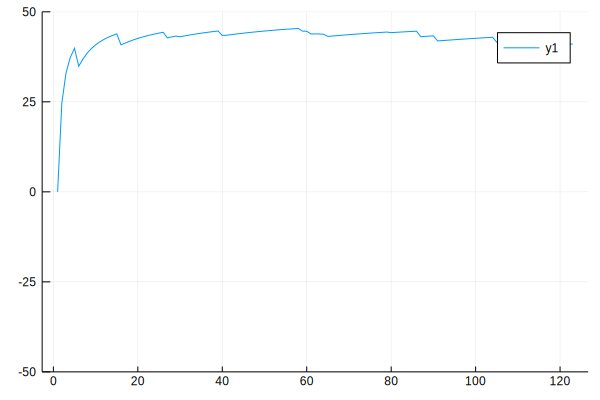

In [41]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-50,50))

In [10]:
#θ = convert(Matrix, CSV.read("good.csv"))


28080×6 Array{Float64,2}:
  0.106108  0.0  -0.0829134  0.0   0.0743955  0.0
 -0.218553  0.0  -1.1224     0.0  -0.0545906  0.0
  0.326478  0.0  -1.73706    0.0  -0.277184   0.0
  0.908624  0.0  -1.52726    0.0   0.388403   0.0
  0.697881  0.0   0.670758   0.0   0.861652   0.0
 -0.10886   0.0  -1.74887    0.0   0.265702   0.0
  0.375173  0.0   1.65491    0.0   0.651283   0.0
  1.15377   0.0   6.51786    0.0   1.21614    0.0
  1.19869   0.0   5.65495    0.0  -0.0774921  0.0
  3.01445   0.0   9.6408     0.0  -0.425889   0.0
  4.68788   0.0   7.16558    0.0   1.04943    0.0
  4.66821   0.0   3.13691    0.0   1.33348    0.0
  6.16342   0.0   2.09777    0.0   1.28498    0.0
  ⋮                                           ⋮  
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0   

In [18]:
θ = convert(Matrix, thetaframe)

28080×6 Array{Float64,2}:
 -1.77704    0.0  -3.91139    0.0  -1.6716    0.0
  0.104306   0.0  -0.277353   0.0   0.29317   0.0
  0.0992801  0.0   2.52568    0.0   1.46481   0.0
  0.892081   0.0   2.81689    0.0   1.36093   0.0
  0.633067   0.0   0.479396   0.0   0.563874  0.0
  1.14868    0.0   0.109032   0.0   0.678002  0.0
  0.651611   0.0  -0.0357058  0.0   0.760664  0.0
  1.14689    0.0   1.85016    0.0   0.111559  0.0
  1.16463    0.0   0.581399   0.0   0.865836  0.0
  1.1367     0.0   1.04617    0.0   1.66769   0.0
  0.345221   0.0   0.929168   0.0   0.788199  0.0
  0.681581   0.0   1.02612    0.0   0.704559  0.0
  0.978036   0.0   0.321273   0.0   1.28954   0.0
  ⋮                                           ⋮  
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0  

In [35]:
thetaframe = DataFrame(θ)
CSV.write("0.474_theta_12.3_1_excellent", thetaframe)

"0.474_theta_12.3_1_excellent"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5